In [204]:
from easypip import easyimport, easyinstall, is_notebook
easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

[easypip] Installing bbrl_gymnasium>=0.2.0
[easypip] Installing bbrl_gymnasium[box2d]
[easypip] Installing bbrl_gymnasium[classic_control]


In [205]:
import os
import sys
from pathlib import Path
import math
import numpy as np

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime

from gymnasium import Env, Space, Wrapper, make

from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
from bbrl.workspace import Workspace
from bbrl.agents import Agents, TemporalAgent
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video
from bbrl.utils.replay_buffer import ReplayBuffer

import torch.nn as nn

from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

from bbrl import instantiate_class

import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from IPython.display import clear_output

import cv2
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten

import random as python_random
import tensorflow as tf

In [206]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [207]:
SEED = 42

# Memes parametres que dans les notebooks, pour le moment on y touche pas mais a changer apres peut etre
params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-buffer-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": SEED,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 100, #MAX ITER 
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [64, 64]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

config=OmegaConf.create(params)

TEST AVEC UN RANDOM AGENT

In [208]:
# meme randomAgent que dans les notebooks
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        self.all_observations = []

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)
        self.all_observations.append(obs)


In [209]:
# on extend le parallelGymAgent pour pouvoir obtenir l'environment des agents
# finalement y pas eu besoin apres donc on peut changer ca mais on fera apres 
# A CHANGER A PRIORI C'EST PLUS UTILE ICI
class CustomParallelGymAgent(ParallelGymAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def get_my_attribute(self):
        return self.envs

In [210]:
#un des agents les plus importants:
#on utilise le CustomParallelGymAgent pour obtenir l'environment d'un agent puis on extrait les informations
#notamment l'image du cartpole a chaque temps t
#avec cette image, on la preprocess et on la passe dans un cnn (defini plus bas)
class AttributeAccessAgent(Agent):
    def __init__(self, env_agent, pre_processing_agent, cnn_agent):
        super().__init__()
        #les agents
        self.env_agent = env_agent  # CustomParallelGymAgent ou ParallelGymAgent
        self.pre_processing_agent = pre_processing_agent
        self.cnn_agent = cnn_agent
        #init de la liste de listes pour store les images
        self.list_images = [[] for _ in range(self.env_agent.num_envs)]
        self.list_features = [[] for _ in range(self.env_agent.num_envs)]
    
    def forward(self, t: int, **kwargs):
        #ici on fait le forward pour chaque agent (donc en fonction du nombre d'environments)
        for env_index in range(self.env_agent.num_envs):
            image = self.env_agent.envs[env_index].render() #on recupere l'image
            display = False #pour afficher en temps reel mais pas utile pour +1 env
            if display: #print a chaque temps l'image originale
                clear_output(wait=True)   
                plt.imshow(image)  
                plt.axis('off')
                plt.show()
                print("Displayed image at time", t, " of agent ", env_index)
            #print(image.shape)
            
            image_pre_processed = self.pre_processing_agent.preprocess(image) #image renvoyee pas le preprocesseur

            self.list_images[env_index].append(image_pre_processed) #on ajoute au bon endroit dans la liste

            # attention a bien mettre l'image preprocessed ici sinon y a des pb avec le cnn
            features = self.cnn_agent.process_image(image_pre_processed) 
            #print(features.shape)
            self.list_features[env_index].append(features) #on ajoute pareil pour les features

In [211]:
# agent pour gerer le preprocessing, rien de trop particulier
# on pourrait faire du preprocessing plus complexe si jamais on obtient des mauvais resultats
class PreProcessingAgent(Agent):
    def __init__(self):
        super().__init__()

    def preprocess(self, image):
        processed_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  #on mets en noir et blanc
        processed_image = cv2.resize(processed_image, (224, 224))  #on rescale 
        return processed_image #image de taille (224, 224)

In [212]:
#modele CNN: c'est une implementation plutot basqiue de cnn, truc classique qu'on trouve sur internet
#on fait avec 5 layers pcq a priori ca devrait suffire
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16 x 112 x 112
            
            #layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 56 x 56
            
            #layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 28 x 28
            
            #layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 14 x 14
            
            #layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256 x 7 x 7
        )
        
        self.fc_layers = nn.Sequential( #on cherche a avoir un vecteur de taille 128 (une ligne)
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  
        )
        
    def forward(self, x): #ici c'est l'image qui a ete converti en tensor
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [213]:
# l'agent cnn qui implemente le modele cnn defini en haut
class CNNAgent(Agent):
    def __init__(self):
        super().__init__()
        self.cnn = CNN() #le cnn

    def process_image(self, image):
        #on converti l'image (preprocessed) en un tensor qu'on peut mettre dans le cnn
        #taille [1, 1, 224, 224], batch_size, channels, height, width
        image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0).unsqueeze(0)  
        image_tensor = image_tensor / 255.0   #petite normalisation

        with torch.no_grad(): #on calcule pas le gradient (a voir si on le fait apres)
            features = self.cnn(image_tensor)
        features = features.cpu().numpy()
        return torch.tensor(features) #on renvoie le vecteur


In [214]:
#petite fonction pour afficher toutes les etapes d'une execution d'un agent dans un environement
def displayImagesPerAgent(images_per_agent):
    n_cols = 4  # nb de colonnes avec des images a afficher
    
    for env_index, images in enumerate(images_per_agent):
        print(f"Environment {env_index + 1}:")
        n_images = len(images)
        n_rows = (n_images + n_cols - 1) // n_cols  #nb de lignes

        #trucs a changer pour l'affichage mais pas beosin d'y toucher je pense
        figsize_width = 10  
        figsize_height = n_rows * (figsize_width / n_cols) * 0.5 
        plt.figure(figsize=(figsize_width, figsize_height))

        for i, image in enumerate(images):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image)
            plt.axis('off')  
        
        plt.tight_layout()
        plt.show()

Donzo got all images
Environment 1:


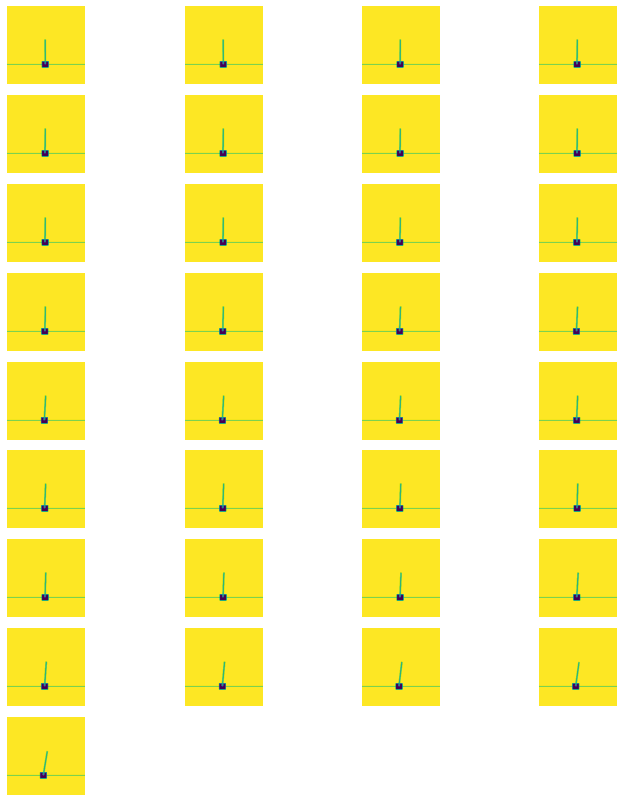

[[tensor([[-3.5232e-02,  3.4520e-02, -4.9284e-02,  1.8581e-02,  5.6171e-02,
         -3.7972e-02, -3.8392e-02, -1.6673e-02, -2.3402e-02, -2.6462e-02,
          2.1023e-02,  8.2540e-03, -4.1140e-02,  2.6189e-02,  5.0826e-02,
         -2.8711e-02,  6.8435e-02, -8.7176e-03, -4.9844e-02,  6.6019e-02,
          4.9121e-02, -3.8391e-03, -2.2627e-02,  5.6182e-03, -5.0710e-02,
         -2.6878e-02, -2.6377e-02,  4.6469e-02, -7.4156e-02,  2.7458e-02,
         -4.0750e-03, -2.3563e-02,  6.1263e-02, -2.4933e-02, -1.6936e-02,
          5.0571e-02,  3.0584e-02, -2.5892e-02,  5.8253e-02,  4.4058e-02,
          1.1277e-02,  3.5478e-02, -7.4194e-06, -5.3268e-02,  5.6225e-02,
          4.3317e-02, -3.3221e-02, -1.3057e-02,  4.5785e-02, -2.6849e-02,
         -8.4723e-03, -4.8433e-02,  7.8260e-02, -3.3188e-05, -4.2509e-02,
         -2.7538e-02, -4.7870e-03, -4.7063e-02,  6.9257e-02, -6.6147e-02,
         -4.7960e-03, -9.5401e-03, -2.2567e-02,  4.5196e-02,  5.8690e-02,
          3.3231e-02, -1.4551e-02, -

In [215]:
workspace = Workspace()
nb_env = 1 #changer le nombre d'environements qu'on veut ici
action_dim = 2 #vaudrait mieux prednre depuis le parallelgymagent mais ca va jamais changer ici
autoreset = False #pour le moment pouor le simplifier la vie
pre_processing_agent = PreProcessingAgent()
cnn_agent = CNNAgent()

im_env_agent = CustomParallelGymAgent(partial(make_env, config.gym_env.env_name, render_mode="rgb_array", autoreset=autoreset), nb_env).seed(SEED)
attribute_access_agent = AttributeAccessAgent(im_env_agent, pre_processing_agent, cnn_agent)
agents = Agents(im_env_agent, RandomAgent(action_dim), attribute_access_agent)
t_agents = TemporalAgent(agents)


t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)
images = attribute_access_agent.list_images 
print('Donzo got all images')
displayImagesPerAgent(images)
print(attribute_access_agent.list_features)

OK ON VA ESSAYER DE FAIRE UN AGENT DQN MAINTENANT

In [221]:
params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-simple-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 3,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 2,
    "n_steps": 32,
    "eval_interval": 2000,
    "nb_measures": 200,
    "nb_evals": 10,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [128, 128]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 2e-3,
  }
}

cfg=OmegaConf.create(params)
pre_processing_agent = PreProcessingAgent()
cnn_agent = CNNAgent()

In [222]:
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    """Helper function to build a multi-layer perceptron (function from $\mathbb R^n$ to $\mathbb R^p$)
    
    Args:
        sizes (List[int]): the number of neurons at each layer
        activation (nn.Module): a PyTorch activation function (after each layer but the last)
        output_activation (nn.Module): a PyTorch activation function (last layer)
    """
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

#QUAND UN BUILD LE MLP FAUT QUE sizes SOIT DU TYPE [128, 64, 2]
#ex: mlp = build_mlp(sizes=[128] + [64, 64] + [2], activation=nn.ReLU(), output_activation=nn.Identity())

In [223]:
def get_env_agents(cfg) -> Tuple[GymAgent, GymAgent]:
    # Returns a pair of environments (train / evaluation) based on a configuration `cfg`
    
    # Train environment
    train_env_agent = ParallelGymAgent(
        partial(make_env,  cfg.gym_env.env_name, render_mode="rgb_array", autoreset=False),
        cfg.algorithm.n_envs
    ).seed(cfg.algorithm.seed)

    # Test environment
    eval_env_agent = ParallelGymAgent(
        partial(make_env, cfg.gym_env.env_name, render_mode="rgb_array"), 
        cfg.algorithm.nb_evals
    ).seed(cfg.algorithm.seed)

    return train_env_agent, eval_env_agent

train_env_agent, eval_env_agent = get_env_agents(cfg)


Petit soucis a priori: apres avoir regarde dans le code source de bbrl, je crois qu'on peut pas rajouter de variables dans le workspace. Donc il faut contourner ce probleme et utiliser d'autres methodes.